In [697]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
The following block remove outliers, insignificant columns and correlated values from the initial file `local_global_res_13_12.csv`

In [698]:
data = pd.read_csv('./data/local_global_res_13_12.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36454 entries, 0 to 36453
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0.1   36454 non-null  int64  
 1   Unnamed: 0     36010 non-null  float64
 2   train_time     36280 non-null  float64
 3   forecast_time  36280 non-null  float64
 4   MAE            36280 non-null  float64
 5   MSE            36280 non-null  float64
 6   RMSE           36280 non-null  float64
 7   MASE           36280 non-null  float64
 8   RMSSE          36280 non-null  float64
 9   MAPE           36280 non-null  float64
 10  SMAPE          36280 non-null  float64
 11  naming_orig    36454 non-null  object 
 12  model_name     36454 non-null  object 
 13  dataset_name   36454 non-null  object 
 14  horizon        36454 non-null  int64  
 15  split          36454 non-null  object 
 16  pred_time      0 non-null      float64
dtypes: float64(11), int64(2), object(4)
memory usage: 

Let's look at the data and display the number of unique values for each column. If column contains numeric data, min and max values (excluding NaNs) are displayed also.

### Duplicates and irrelevant columns handling
First of all, we remove all the irrelevant data, duplicates nad artefacts from the dataset.

In [699]:
print(f'Duplicated rows:\n{data.duplicated()}\n')
print(f'Rows with NaN:\n{data.isna().sum()}\n')

Duplicated rows:
0        False
1        False
2        False
3        False
4        False
         ...  
36449    False
36450    False
36451    False
36452    False
36453    False
Length: 36454, dtype: bool

Rows with NaN:
Unnamed: 0.1         0
Unnamed: 0         444
train_time         174
forecast_time      174
MAE                174
MSE                174
RMSE               174
MASE               174
RMSSE              174
MAPE               174
SMAPE              174
naming_orig          0
model_name           0
dataset_name         0
horizon              0
split                0
pred_time        36454
dtype: int64



In [700]:
data

,Unnamed: 0.1,Unnamed: 0,train_time,forecast_time,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE,naming_orig,model_name,dataset_name,horizon,split,pred_time
0,0,0.0,3.812914,4.442261,18.260277,619.323792,24.886217,0.896638,0.792087,inf,16.386864,danish_atm_daily_5,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,test,NaN
1,1,0.0,3.485261,4.376619,28.395468,1160.189331,34.061552,1.088141,0.918072,41.157335,17.157184,danish_atm_daily_84,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
2,2,0.0,3.812914,4.442261,12.825266,269.356567,16.412086,0.814535,0.757765,39.022604,13.038494,danish_atm_daily_32,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,test,NaN
3,3,0.0,3.485261,4.376619,26.284388,1121.348877,33.486548,0.918232,0.792925,57.078475,18.962322,danish_atm_daily_25,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
4,4,0.0,3.485261,4.376619,15.145726,429.357697,20.720948,0.663444,0.597604,21.996029,10.027625,danish_atm_daily_6,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36449,0,NaN,225.815618,1.806664,2.762839,11.352131,3.369292,0.779592,0.688223,20.044580,8.785076,nn5_98,DeepARTuningObjective,nn5,30,validation,NaN
36450,0,NaN,221.914140,1.835336,2.712137,16.868277,4.107101,0.679580,0.778644,29.559124,10.474208,nn5_99,DeepARTuningObjective,nn5,30,test,NaN
36451,0,NaN,225.815618,1.806664,1.519503,3.326512,1.823873,0.381234,0.345513,11.370875,5.622922,nn5_99,DeepARTuningObjective,nn5,30,validation,NaN
36452,0,NaN,221.914140,1.835336,3.380999,22.316181,4.724001,0.658609,0.684295,23.539458,8.428656,nn5_9,DeepARTuningObjective,nn5,30,test,NaN


In [701]:
from pandas.api.types import is_numeric_dtype

sizes = pd.DataFrame(index=data.columns, columns=['unique_values', 'min', 'max'])

for col in data.columns:
    # For each column calculate number of unique values
    sizes.loc[col]['unique_values'] = len(data[col].unique())
    if is_numeric_dtype(data[col]):
        try:
            # If data type is numeric, try to calculate min and max values,
            # excluding NaNs
            sizes.loc[col]['min'] = np.min(data[col].dropna().unique())
            sizes.loc[col]['max'] = np.max(data[col].dropna().unique())
        except:
            # If column contains only NaNs, write NaN to both columns
            sizes.loc[col][['min', 'max']] = np.nan
    else:
        # If data type isn't numeric, write N/A - Not Applicable
        sizes.loc[col][['min', 'max']] = "N/A"

sizes

,unique_values,min,max
Unnamed: 0.1,36010,0,36009
Unnamed: 0,2,0.0,0.0
train_time,18633,0.00006,28655.271598
forecast_time,17056,0.000003,189.939747
MAE,29656,0.027207,8756287.0
MSE,29666,0.00074,115030313926656.0
RMSE,29666,0.027207,10725218.595752
MASE,29711,0.0,26820764541.625977
RMSSE,29715,0.0,26857884266.368134
MAPE,23749,6.512892,inf


As we can see, the `pred_time`, `horizon`, `Unnamed: 0` and `Unnamed: 0.1` columns can be dropped. Two latter columns are artefacts from files concatenation. `horizon` column contains only single value, `dataset_name` is redundant due to the fact, that dataset_name is included into time series name. `pred_time` contains no valuable data.

In [702]:
data = data.drop(['pred_time', 'horizon', 'Unnamed: 0', 
                  'Unnamed: 0.1', 'dataset_name'], axis=1)
data = data.dropna()

### Outliers handling
Secondly, the outliers are removed. We decided, that outliers can be no more that 2.5% of the total data volume.

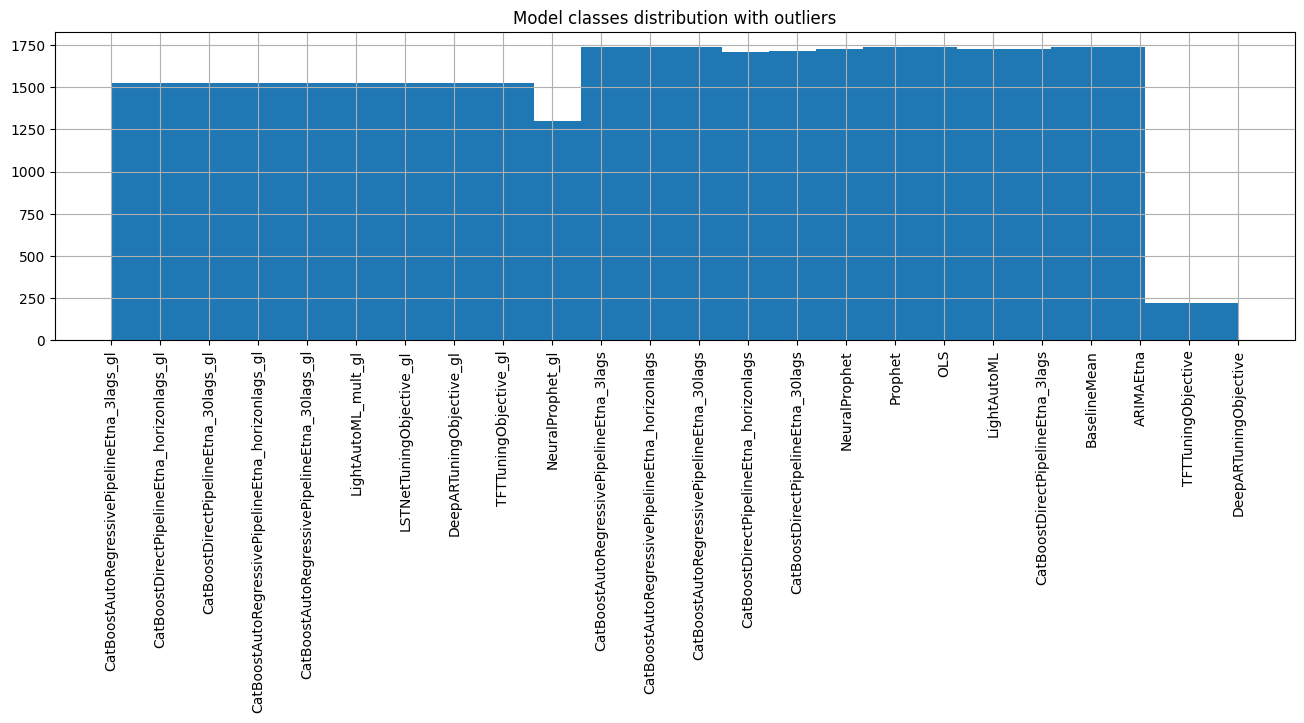

In [703]:
# Depict classes distribution histogram
fig = plt.figure(figsize=(16,4))
plt.hist(data['model_name'], bins=24)
plt.xticks(rotation=90); plt.grid()
plt.title('Model classes distribution with outliers')
plt.show()

Now, we will look at the remained numerical values to find anomalies using box plots.

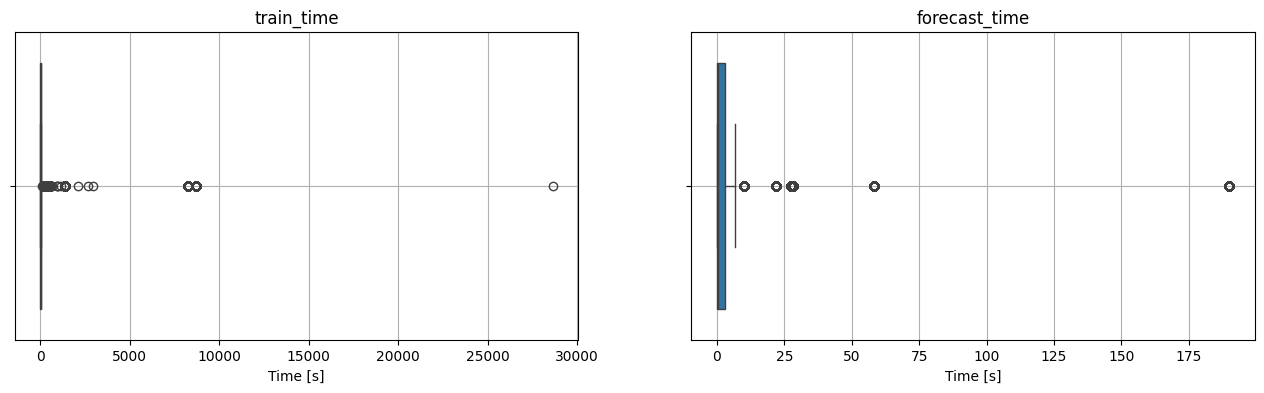

In [704]:
# Depict time metrics boxplots
times = ['train_time', 'forecast_time']
rows = 1

fig, axes = plt.subplots(nrows=rows, ncols=len(times)//rows, figsize=(16, 4))

for ax, time in zip(axes.flatten(), times):
    sns.boxplot(data[time], ax=ax, orient='h')
    ax.grid()
    ax.set_title(time)
    ax.set_xlabel('Time [s]')

plt.show()

We can see, that there is an outlier w.r.t. to the train time.

In [705]:
data[data['train_time'] > 10000]

,train_time,forecast_time,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE,naming_orig,model_name,split
27920,28655.271598,0.262712,850909.875,1.127550e+12,1.061862e+06,0.927062,0.873742,65.280634,17.660116,mipt_alpha_40,LightAutoML,validation


In [706]:
data = data.drop(data[data['train_time'] > 10000].index)

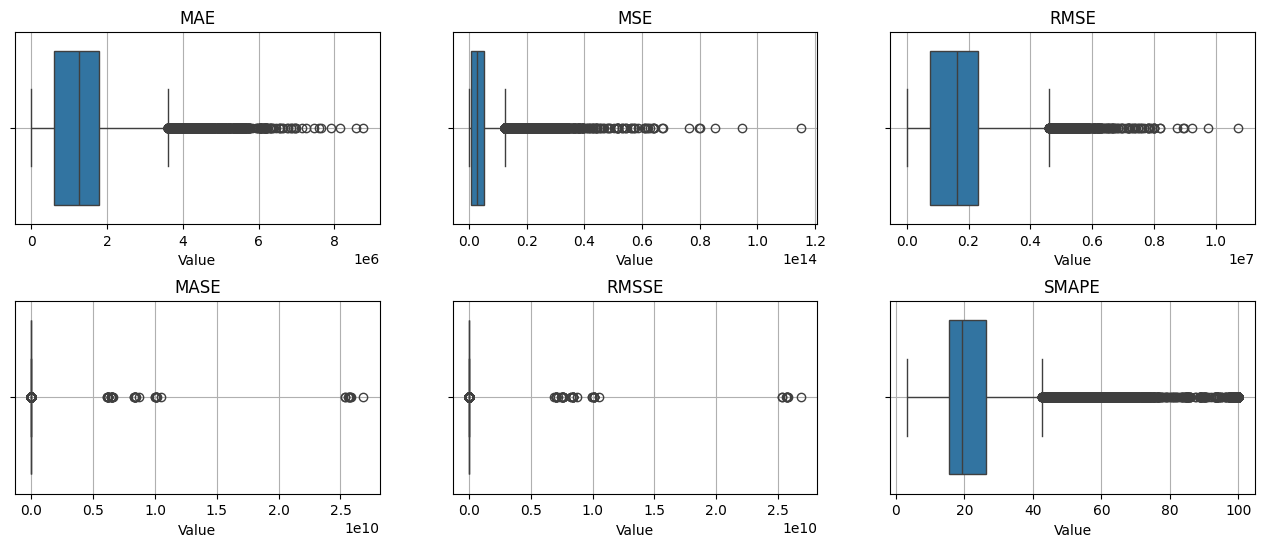

In [707]:
# Depict quality metrics boxplots
labels = data.select_dtypes(include=np.number).columns.tolist()
labels = [l for l in labels if l not in times]
labels.remove('MAPE')
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=len(labels)//rows, figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    sns.boxplot(data[label], ax=ax, orient='h')
    ax.grid()
    ax.set_title(label)
    ax.set_xlabel('Value')

plt.show()

We decided to ignore MAPE because of the metric unstability. As we can see, MAPE metrics become ill-contitioned whenever $y_i \in U(0)$, because
$$\text{MAPE}=100\% \times \frac{1}{n}\sum_{i=1}^{n}\frac{|y_i-\hat{y_i}|}{|y_i|},$$

where:

$y_i$ - time series i-th value;

$\hat{y_i}$ - predicted i-th value.

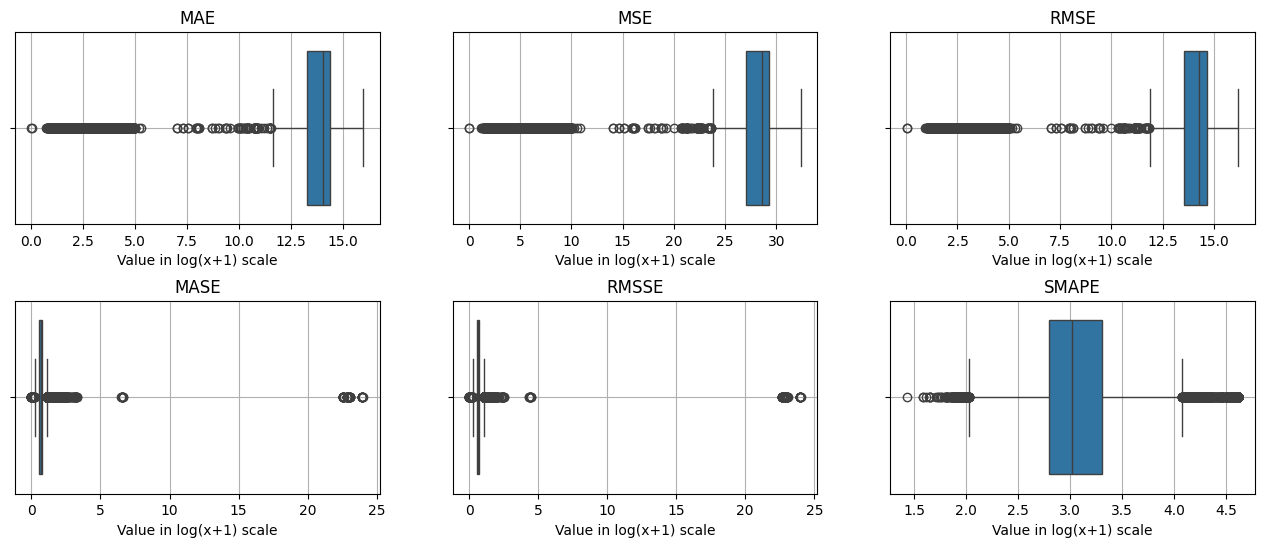

In [708]:
# Depict time metrics boxplots in log(1+x) scale
fig, axes = plt.subplots(nrows=rows, ncols=len(labels)//rows, figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    sns.boxplot(np.log1p(data[label]), ax=ax, orient='h')
    ax.grid()
    ax.set_title(f'{label}')
    ax.set_xlabel('Value in log(x+1) scale')

plt.show()

It is obvious, that MASE and RMSSE in the $\log(x+1)$ scale highlight outliers. We have tried several threshold for MASE, RMSSE and RMSE and decided to apply the following threshold

$$S=\lbrace y_i, X_i \rbrace_{i=1}^m: \forall X \in S \Rightarrow X_{\text{MASE}} \leq 6 \cap X_{\text{RMSSE}} \leq 4 \cap X_{\text{RMSE}} \leq 6\cdot10^6.$$

In [709]:
rmsse_th = 4
mase_th = 6
rmse_th = 6e6

outliers = len(data[(data['MASE'] > mase_th) | (data['RMSSE'] > rmsse_th) | (data['RMSE'] > rmse_th)])
print(f'Number of rows with MASE > {mase_th:.2f} or RMSSE > {rmsse_th:.2f}: {outliers}')
print(f'Outliers rate: {outliers/len(data):.2%}')

Number of rows with MASE > 6.00 or RMSSE > 4.00: 371
Outliers rate: 1.02%


In [710]:
data[(data['MASE'] > mase_th) | (data['RMSSE'] > rmsse_th) | (data['RMSE'] > rmse_th)]

,train_time,forecast_time,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE,naming_orig,model_name,split
53,3.812914,4.442261,6.131524e+00,5.661726e+01,7.524444e+00,6.131524e+09,7.524444e+09,inf,39.032561,danish_atm_daily_111,CatBoostAutoRegressivePipelineEtna_3lags_gl,test
75,3.812914,4.442261,1.281847e+01,3.654213e+02,1.911600e+01,7.135613e+02,8.234437e+01,1.571075e+02,25.457659,danish_atm_daily_110,CatBoostAutoRegressivePipelineEtna_3lags_gl,test
78,3.485261,4.376619,1.050156e+01,1.104596e+02,1.050998e+01,1.050156e+10,1.050998e+10,inf,100.000000,danish_atm_daily_111,CatBoostAutoRegressivePipelineEtna_3lags_gl,validation
96,3.485261,4.376619,1.911140e+01,7.075344e+02,2.659952e+01,9.764479e+00,3.511760e+00,6.267861e+01,20.730352,danish_atm_daily_109,CatBoostAutoRegressivePipelineEtna_3lags_gl,validation
103,3.812914,4.442261,2.217719e+01,7.893629e+02,2.809560e+01,6.116581e+00,2.549262e+00,inf,25.884894,danish_atm_daily_109,CatBoostAutoRegressivePipelineEtna_3lags_gl,test
...,...,...,...,...,...,...,...,...,...,...,...,...
34391,0.000098,0.000006,5.552962e+06,4.051247e+13,6.364941e+06,1.457118e+00,1.285354e+00,7.166476e+01,30.613497,mipt_alpha_62,BaselineMean,test
34427,0.000095,0.000005,7.656762e+06,7.635579e+13,8.738180e+06,7.646467e+00,5.611784e+00,7.304923e+01,59.663522,mipt_alpha_368,BaselineMean,test
34533,0.000091,0.000005,5.526198e+06,3.951878e+13,6.286397e+06,1.821848e+00,1.600046e+00,inf,49.245909,mipt_alpha_245,BaselineMean,test
34632,0.000087,0.000005,6.103602e+06,5.177452e+13,7.195451e+06,2.474979e+00,1.941867e+00,2.257296e+16,32.594907,mipt_alpha_366,BaselineMean,test


As the number of outliers slightly exceeds 1%, we can drop them out.

In [711]:
data = data.drop(data[
                 (data['MASE'] > mase_th) | 
                 (data['RMSSE'] > rmsse_th) | 
                 (data['RMSE'] > rmse_th)
                 ].index)

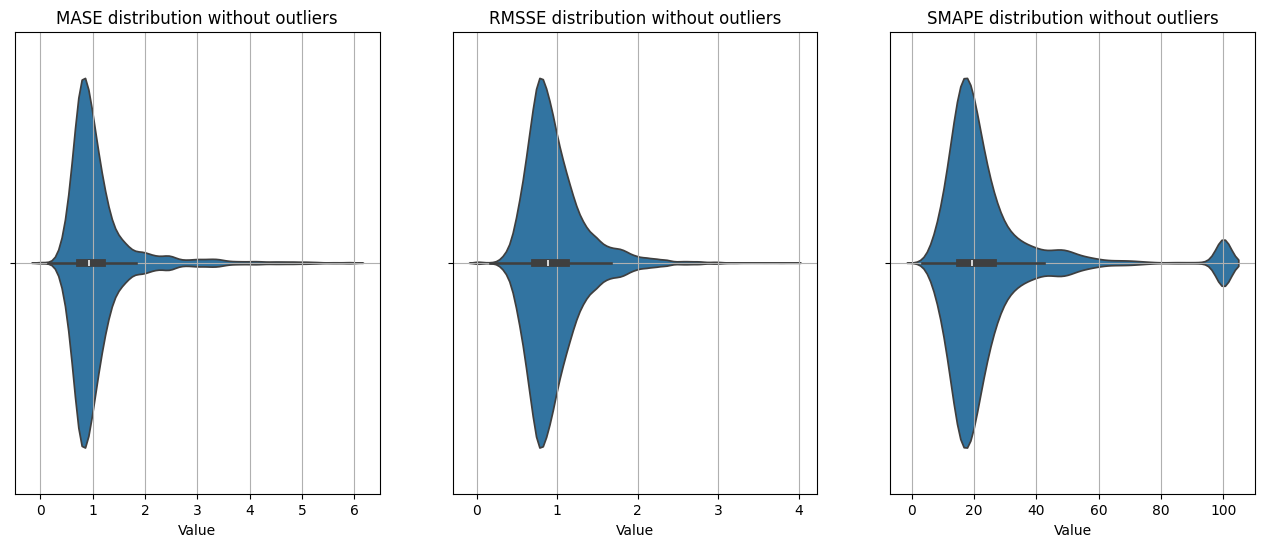

In [712]:
# Depict final metrics
labels = ['MASE', 'RMSSE', 'SMAPE']

fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    ax.set_xlabel('Value')
    sns.violinplot(data[label], ax=ax, orient='h')
    ax.grid()
    ax.set_title(f'{label} distribution without outliers')

plt.show()

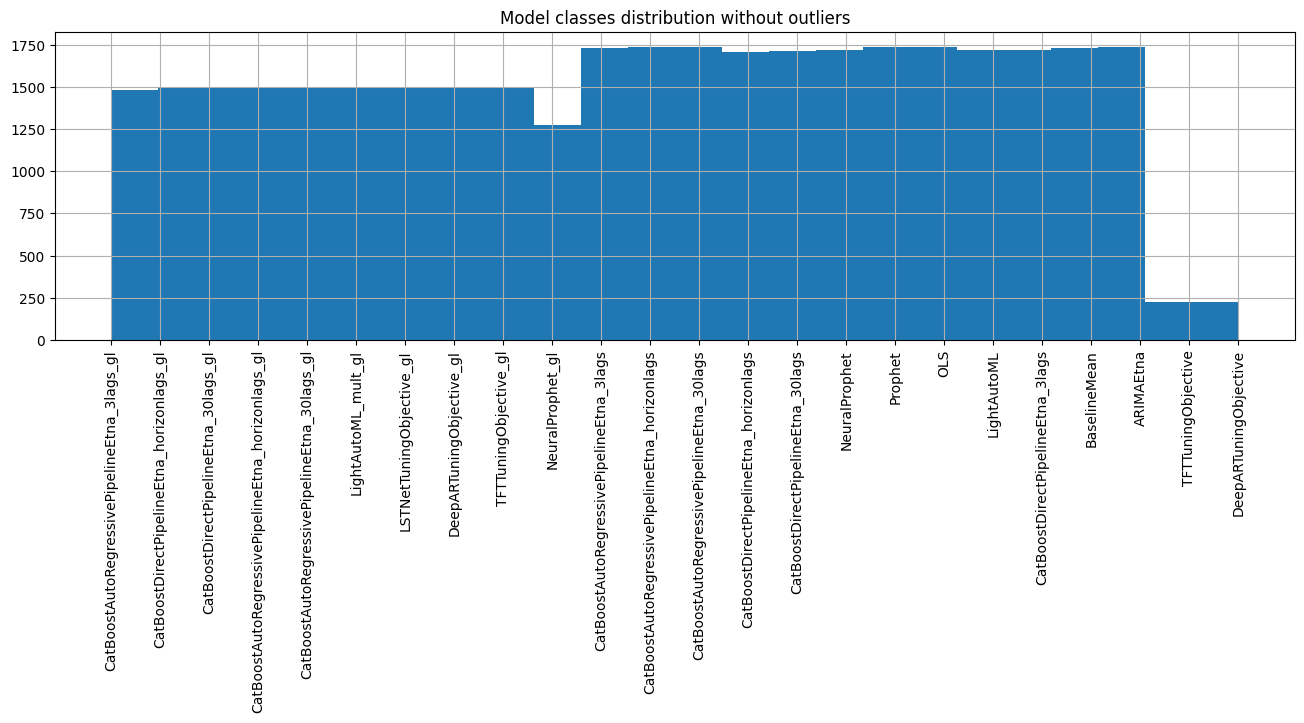

In [713]:
fig = plt.figure(figsize=(16,4))
plt.hist(data['model_name'], bins=24)
plt.xticks(rotation=90); plt.grid()
plt.title('Model classes distribution without outliers')
plt.show()

### Correlated values handling
Now, let's look at metrics correlation and drop out the correlated ones.

NB: all the correlation matrix below contains **absolute** correlation value, thus the sign of linear dependence is not accounted for. 

In [714]:
metrics = data.select_dtypes(include=np.number).columns.tolist()
np.abs(data[metrics].corr()).style.format("{:.2f}").background_gradient(cmap='Reds', high=1.01)

,train_time,forecast_time,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE
train_time,1.00,0.08,0.07,0.04,0.07,0.07,0.04,0.03,0.04
forecast_time,0.08,1.00,0.11,0.07,0.11,0.10,0.08,0.03,0.05
MAE,0.07,0.11,1.00,0.93,0.99,0.29,0.44,0.06,0.34
MSE,0.04,0.07,0.93,1.00,0.92,0.28,0.45,0.04,0.31
RMSE,0.07,0.11,0.99,0.92,1.00,0.24,0.42,0.06,0.26
MASE,0.07,0.10,0.29,0.28,0.24,1.00,0.87,0.02,0.52
RMSSE,0.04,0.08,0.44,0.45,0.42,0.87,1.00,0.02,0.48
MAPE,0.03,0.03,0.06,0.04,0.06,0.02,0.02,1.00,0.34
SMAPE,0.04,0.05,0.34,0.31,0.26,0.52,0.48,0.34,1.00


Let's drop out MAE and MSE, which correlate to the RMSE. Repeat the same with MASE and MAPE.

In [715]:
data = data.drop(['MAE', 'MSE', 'MASE', 'MAPE'], axis=1)

In [716]:
metrics = data.select_dtypes(include=np.number).columns.tolist()
np.abs(data[metrics].corr()).style.format("{:.2f}").background_gradient(cmap='Reds', high=1.01)

,train_time,forecast_time,RMSE,RMSSE,SMAPE
train_time,1.00,0.08,0.07,0.04,0.04
forecast_time,0.08,1.00,0.11,0.08,0.05
RMSE,0.07,0.11,1.00,0.42,0.26
RMSSE,0.04,0.08,0.42,1.00,0.48
SMAPE,0.04,0.05,0.26,0.48,1.00


We decided to introudce cumulative normalized metric, which can be calculated as follow:

$$CM(X)=\frac{1}{\sum_{i=1}^{n}\omega_i}\sum_{i=1}^{n}\omega_i\exp(-x_i),$$

where:

$X=(x_1,...,x_n)$ - metrics vector;

$\omega_1,...,\omega_n$ - metrics weights.

In [717]:
def cumulative_metric(metrics, time, time_weight=0.15, greater_is_better=True):
    result = np.zeros(time.shape)
    # Add and normalize every metric with exp(-x)
    for metric in metrics:
        result = result + np.exp(-metric)
    # Add the weighted time metric
    result = result + time_weight*np.exp(-time)
    # Normalize result w.r.t. metrics weight 
    result = result / (len(metrics)+time_weight)
    # For inverse criteria
    if ~greater_is_better: result = 1 - result
        
    return result

In [718]:
data['CM'] = cumulative_metric([data['RMSE'], data['RMSSE'], data['SMAPE']], 
                                       data['train_time'] + data['forecast_time'])

In [719]:
metrics = data.select_dtypes(include=np.number).columns.tolist()
np.abs(data[metrics].corr()).style.format("{:.2f}").background_gradient(cmap='Reds', high=1.01)

,train_time,forecast_time,RMSE,RMSSE,SMAPE,CM
train_time,1.00,0.08,0.07,0.04,0.04,0.09
forecast_time,0.08,1.00,0.11,0.08,0.05,0.15
RMSE,0.07,0.11,1.00,0.42,0.26,0.46
RMSSE,0.04,0.08,0.42,1.00,0.48,0.89
SMAPE,0.04,0.05,0.26,0.48,1.00,0.43
CM,0.09,0.15,0.46,0.89,0.43,1.00


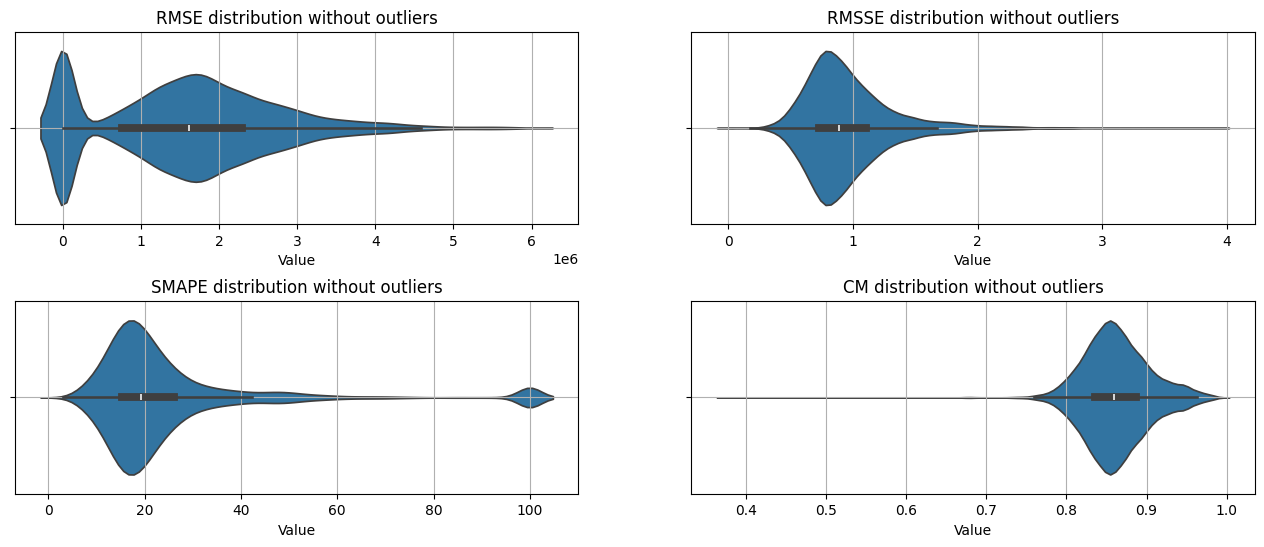

In [720]:
# Depicts final metrics distribution
labels = ['RMSE', 'RMSSE', 'SMAPE', 'CM']
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=len(labels)//rows, figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    ax.set_xlabel('Value')
    sns.violinplot(data[label], ax=ax, orient='h')
    ax.grid()
    ax.set_title(f'{label} distribution without outliers')
    

plt.show()
fig.savefig('./output/final_metrics', dpi=300)

### Dataset split
Prepare both training and test datasets. Fill them with the best method for every time series.

In [721]:
def best_method(input, index, label, criteria, na_handling=np.nan, 
                greater_is_better=False):

    '''
    Function which extracts best model from results table w.r.t. listed criteria

    Parameters
    ----------
    input : DataFrame,
        table with results
    index : str,
        column, from which data will be used as a row index
    label : str,
        column, which contains method name or label
    criteria : list,
        set of criteria, which will be used to find best method
    na_handling : np.number,
        value for handling the missed values
    greater_is_better : bool,
        setting to choose either greatest or lowest value from criteria

    Returns
    ----------
    best_results : DataFrame,
        table which rows contains unique values from 'index' column;
        there are len(criteria)+1 columns: 1st contains values from 'rows'
        column, other columns contain label with the best method w.r.t to
        stated criteria
    '''

    # Prepare rows columns for the table
    rows = input[index].unique()
    # Prepare columns for criteria values and model names
    suffs = ['', '-model']; cols = []
    for suf in suffs: for criterion in criteria: cols.append(criterion+suff)
    cols = np.concatenate(([index], cols))
    # Define dataframe
    best_results = pd.DataFrame(index=rows, columns=cols, data=na_handling)
    best_results[index] = rows

    # Iterate over timeseries and criteria
    for row in rows:
        batch = input[input[index]==row]
        for criterion in criteria:
            # If parameter is toggled True, find the greatest value.
            # Otherwise - the lowest one
            if greater_is_better:
                best_model = batch.iloc[batch[criterion].argmax()]
            else:
                best_model = batch.iloc[batch[criterion].argmin()]
            best_results.loc[row, criterion+suffs[0]] = best_model.loc[criterion]
            best_results.loc[row, criterion+suffs[1]] = best_model.loc[label]
            
    # Substitute temporary indexes with integers
    best_results.index = np.arange(len(rows))
    return best_results

In [722]:
# Extract training dataset from the initial table
train = data[data['split']=='validation']
train = train.drop(labels=['split'], axis=1)
# Create table with best methods for each time series
train = best_method(train, 'naming_orig', 'model_name', 
                    ['RMSE', 'RMSSE', 'SMAPE', 'CM'])
train.to_csv('./data/train_dataset.csv')
train

In [723]:
# Extract test dataset from the initial table
test = data[data['split']=='test']
test = test.drop(labels=['split'], axis=1)
# Create table with best methods for each time series
test = best_method(test, 'naming_orig', 'model_name', 
                    ['RMSE', 'RMSSE', 'SMAPE', 'CM'])
test.to_csv('./data/test_dataset.csv')
test